#Text-Image Search and Image-Image Search using CLIP Approach by Finetuning on Custom Dataset

#1. Installing dependencies

In [1]:
!pip install torch==2.0.0 -f https://download.pytorch.org/whl/cu111/torch_stable.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/cu111/torch_stable.html
  Using cached torch-2.0.0-cp310-cp310-manylinux1_x86_64.whl (619.9 MB)
  Attempting uninstall: torch
    Found existing installation: torch 2.0.1
    Uninstalling torch-2.0.1:
      Successfully uninstalled torch-2.0.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.15.2 requires torch==2.0.1, but you have torch 2.0.0 which is incompatible.


In [2]:
!pip uninstall -y torchaudio torchdata torchtext torchvision

Found existing installation: torchvision 0.15.2
Uninstalling torchvision-0.15.2:
  Successfully uninstalled torchvision-0.15.2


In [3]:
!pip install torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached torchvision-0.15.2-cp310-cp310-manylinux1_x86_64.whl (6.0 MB)
  Using cached torch-2.0.1-cp310-cp310-manylinux1_x86_64.whl (619.9 MB)
  Attempting uninstall: torch
    Found existing installation: torch 2.0.0
    Uninstalling torch-2.0.0:
      Successfully uninstalled torch-2.0.0


In [4]:
!pip install -qU transformers torch datasets gdcm pydicom pinecone-client
!pip install openai-clip
!pip install gdcm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached openai_clip-1.0.1-py3-none-any.whl
  Using cached ftfy-6.1.1-py3-none-any.whl (53 kB)
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#2. Importing required libraries

In [5]:
import os
import torch
import skimage
import requests
import numpy as np
import pandas as pd
from PIL import Image
from io import BytesIO
import IPython.display
import matplotlib.pyplot as plt
from datasets import load_dataset
from collections import OrderedDict
from transformers import CLIPProcessor, CLIPModel, CLIPTokenizer
import torch
import clip
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

# 3. Loading Train Dataset for finetuning

In [6]:
# https://huggingface.co/datasets/conceptual_captions
image_data = load_dataset(
    "ashraq/fashion-product-images-small", split="train",
    )

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/44072 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/ashraq___parquet/ashraq--fashion-product-images-small-909c61a107795b31/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


In [7]:
image_data_df = pd.DataFrame(image_data[:5000])

In [8]:
image_data_df.shape

(5000, 11)

In [9]:
image_data_df.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,<PIL.JpegImagePlugin.JpegImageFile image mode=...
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans,<PIL.JpegImagePlugin.JpegImageFile image mode=...
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch,<PIL.JpegImagePlugin.JpegImageFile image mode=...
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants,<PIL.JpegImagePlugin.JpegImageFile image mode=...
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt,<PIL.JpegImagePlugin.JpegImageFile image mode=...


In [10]:
image_data_df.shape

(5000, 11)

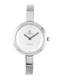

In [11]:
image_data_df.iloc[2]["image"]

In [12]:
image_data_df.iloc[2]["productDisplayName"]

'Titan Women Silver Watch'

In [13]:
image_data_df.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,<PIL.JpegImagePlugin.JpegImageFile image mode=...
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans,<PIL.JpegImagePlugin.JpegImageFile image mode=...
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch,<PIL.JpegImagePlugin.JpegImageFile image mode=...
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants,<PIL.JpegImagePlugin.JpegImageFile image mode=...
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt,<PIL.JpegImagePlugin.JpegImageFile image mode=...


In [14]:
# Define your custom dataset
class CustomDataset(Dataset):
    def __init__(self, image_paths, texts):
        self.image_paths = image_paths
        self.texts = texts
        self.transform = transforms.Compose([
            transforms.Resize(224),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        text = self.texts[idx]
        image = self.transform(self.image_paths[idx].convert("RGB"))
        return image, text

In [15]:
# Define your dataset paths and texts
image_paths = image_data_df["image"].tolist()
texts = image_data_df["productDisplayName"].tolist()

In [16]:
print(image_paths)

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80 at 0x7EFECACC2E60>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80 at 0x7EFECAD13B20>, <PIL.JpegImagePlugin.JpegImageFile image mode=L size=60x80 at 0x7EFECAD13B80>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80 at 0x7EFECAD13EB0>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80 at 0x7EFECAD13F10>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80 at 0x7EFECAD13FA0>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80 at 0x7EFEC03AC220>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80 at 0x7EFEC03AC2B0>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80 at 0x7EFEC03AC340>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80 at 0x7EFEC03AC580>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80 at 0x7EFEC03AC880>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80 at 0x7EFEC03ACAC0>, <PIL.JpegImagePlugin.JpegImag

In [17]:
print(texts)

['Turtle Check Men Navy Blue Shirt', 'Peter England Men Party Blue Jeans', 'Titan Women Silver Watch', 'Manchester United Men Solid Black Track Pants', 'Puma Men Grey T-shirt', 'Inkfruit Mens Chain Reaction T-shirt', 'Fabindia Men Striped Green Shirt', 'Jealous 21 Women Purple Shirt', 'Puma Men Pack of 3 Socks', 'Skagen Men Black Watch', 'Puma Men Future Cat Remix SF Black Casual Shoes', 'Fossil Women Black Huarache Weave Belt', 'Fila Men Cush Flex Black Slippers', 'Murcia Women Blue Handbag', 'Ben 10 Boys Navy Blue Slippers', 'Reid & Taylor Men Check Purple Shirts', 'Police Men Black Dial Watch PL12889JVSB', 'Gini and Jony Girls Knit White Top', 'Bwitch Beige Full-Coverage Bra BW335', 'Baggit Women Brown Handbag', 'CASIO G-Shock Men Black Digital Watch G-7710-1DR G223', 'ADIDAS Men Spry M Black Sandals', 'Timberland Unisex Rubber Sole Brush Shoe Accessories', 'ADIDAS Men Lfc Auth Hood Grey Sweatshirts', 'David Beckham Signature Men Deos', 'Buckaroo Men Flores Black Formal Shoes', 'Pit

# 5. Loading pretrained CLIP Model of ViT variant

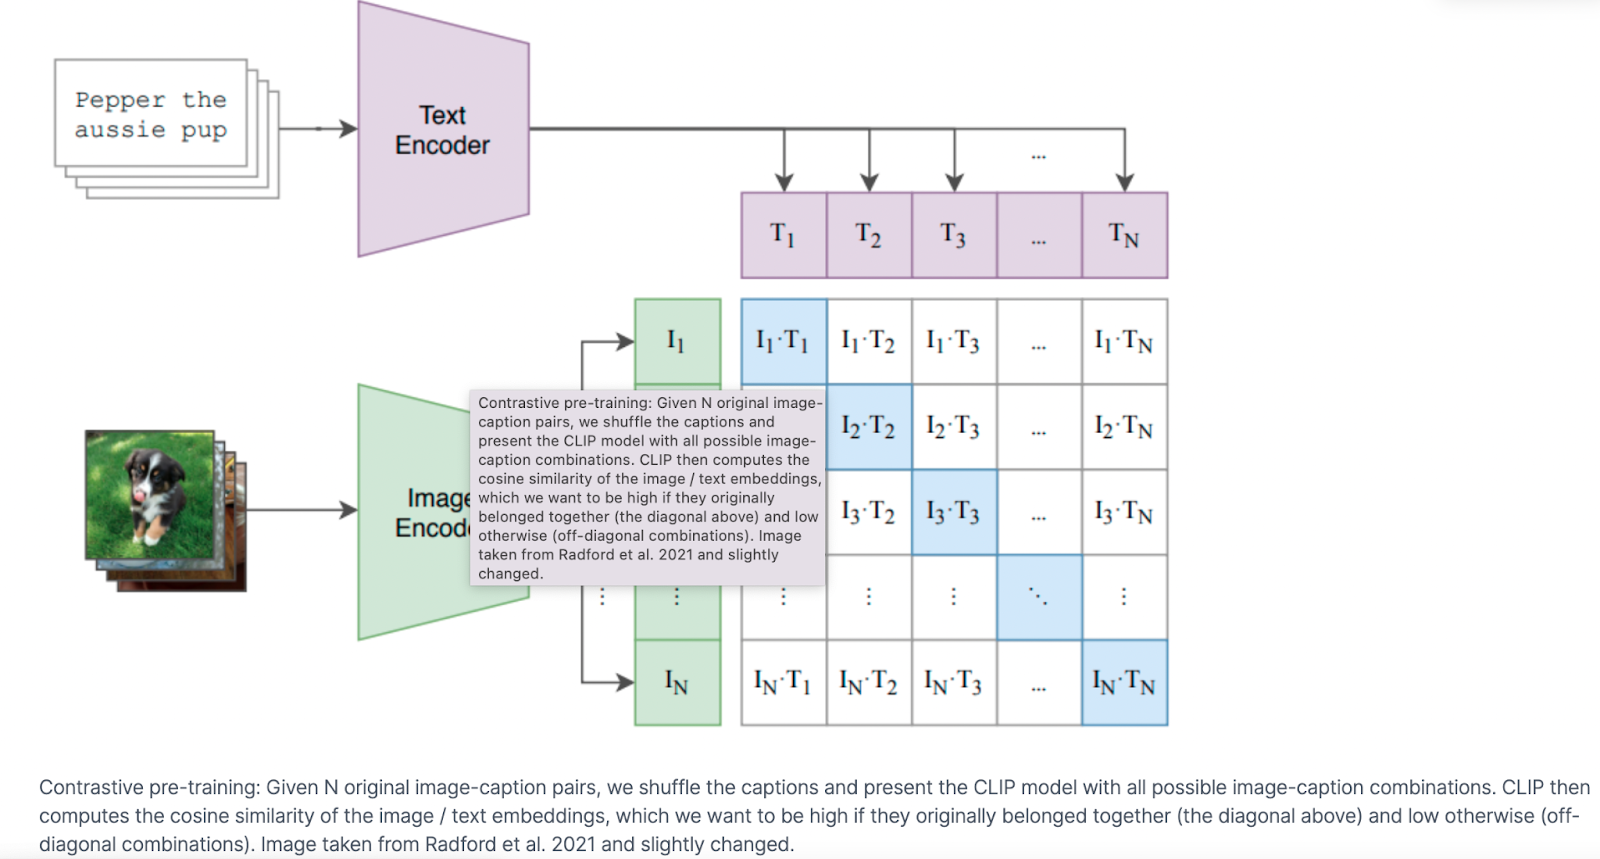

In [18]:
# Initialize and load the pre-trained CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"

#https://github.com/openai/CLIP
# device = "cuda" if torch.cuda.is_available() else "cpu"
# model, preprocess = clip.load("ViT-B/32", device=device)



# https://huggingface.co/openai/clip-vit-base-patch32
model_ID='openai/clip-vit-base-patch32'

# Get the processor
processor = CLIPProcessor.from_pretrained(model_ID)


# Save the model to device
model = CLIPModel.from_pretrained(model_ID).to(device)

# Get the tokenizer
tokenizer = CLIPTokenizer.from_pretrained(model_ID)

In [19]:
# Create an instance of your custom dataset
dataset = CustomDataset(image_paths, texts)

In [20]:
# Define training parameters
batch_size = 32
learning_rate = 1e-5

# Create a data loader
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Set up optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.CosineEmbeddingLoss()

In [21]:
print(data_loader)

for images,texts in data_loader:
    print(images,texts)


Streaming output truncated to the last 5000 lines.
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489]],

         [[2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          ...,
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286]],

         [[2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6400],
          [2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6400],
          [2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6400],
          ...,
          [2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6400],
          [2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6400],
          [2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6400]]]]) ('United Colors of Benetton Women White Tunics', 'Loco

# 6. Fine-tuning with custom dataset

In [23]:
# Fine-tune the CLIP model
num_epochs = 25
model.train()
for epoch in range(num_epochs):
    for images, texts in data_loader:
        optimizer.zero_grad()
        # Encode images and texts
        images = images.to(device)
        texts = clip.tokenize(texts).to(device)
        # image_features = model.encode_image(images)
        # text_features = model.encode_text(texts)

        image_features = model.get_image_features(images)
        text_features = model.get_text_features(texts)

        # Compute the loss
        loss = criterion(image_features, text_features, torch.ones(images.shape[0]).to(device))

        # Backpropagation and optimization
        loss.backward()
        optimizer.step()  

    # Print epoch loss
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}")



KeyboardInterrupt: ignored

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Save the fine-tuned model
torch.save(model.state_dict(), "/content/drive/MyDrive/Saved_Model/CLIP_fine_tuned_model_Fashion.pt")

# 7. Testing the fine-tuned model

In [ ]:
!pip install transformers

In [ ]:
import torch
from transformers import CLIPProcessor, CLIPModel, CLIPTokenizer
model_ID='openai/clip-vit-base-patch32'
# Initialize and load the pre-trained CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
model = CLIPModel.from_pretrained(model_ID).to(device)
model.load_state_dict(torch.load("/content/drive/MyDrive/Saved_Model/CLIP_fine_tuned_model_Fashion.pt"))
model.eval()

In [ ]:

import os
import torch
import skimage
import requests
import numpy as np
import pandas as pd
from PIL import Image
from io import BytesIO
import IPython.display
import matplotlib.pyplot as plt
from datasets import load_dataset
from collections import OrderedDict
from transformers import CLIPProcessor, CLIPModel, CLIPTokenizer
import torch
import clip
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

# https://huggingface.co/datasets/conceptual_captions
image_data_test = load_dataset(
    "ashraq/fashion-product-images-small", split="train",
    )

In [ ]:
image_data_test_df = pd.DataFrame(image_data_test[5001:6001])

In [ ]:
image_data_test_df.shape

In [ ]:
image_data_test_df.head()

In [ ]:
image_data_test_df.iloc[0]["image"]

In [ ]:
image_data_test_df.iloc[0]["productDisplayName"]

In [ ]:
image_data_test_df.head()

In [ ]:
image_paths = image_data_test_df["image"].tolist()
texts = image_data_test_df["productDisplayName"].tolist()

#8. Create Embeddings: Text and Image Embeddings

##a. Text Embeddings

In [ ]:
def get_single_text_embedding(text):

  inputs = tokenizer(text, return_tensors = "pt").to(device)


  #OpenAI CLIP
  # text_embeddings=model.encode_text(inputs)

  #Huggingface CLIP
  text_embeddings = model.get_text_features(**inputs)

  # convert the embeddings to numpy array 
  embedding_as_np = text_embeddings.cpu().detach().numpy()

  return embedding_as_np

In [ ]:
def get_all_text_embeddings(df, text_col):

   df["text_embeddings"] = df[str(text_col)].apply(get_single_text_embedding)

   return df 

In [ ]:
image_data_test_df = get_all_text_embeddings(image_data_test_df, "productDisplayName")

In [ ]:
image_data_test_df.head()

##b. Image Embeddings

In [ ]:
def get_single_image_embedding(my_image):

  image = processor(
      text = None,
      images = my_image, 
      return_tensors="pt"
  )["pixel_values"].to(device)

  embedding = model.get_image_features(image)

  # convert the embeddings to numpy array
  embedding_as_np = embedding.cpu().detach().numpy()

  return embedding_as_np

In [ ]:
def get_all_images_embedding(df, img_column):

  df["img_embeddings"] = df[str(img_column)].apply(get_single_image_embedding)

  return df

In [ ]:
image_data_test_df = get_all_images_embedding(image_data_test_df, "image")

In [ ]:
image_data_test_df.head()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_images(images):

  for image in images:
    plt.imshow(image)
    plt.show()

def plot_images_by_side(top_images):

  index_values = list(top_images.index.values)
  list_images = [top_images.iloc[idx].image for idx in index_values] 
  list_captions = [top_images.iloc[idx].productDisplayName for idx in index_values] 
  similarity_score = [top_images.iloc[idx].cos_sim for idx in index_values] 

  n_row = n_col = 3

  _, axs = plt.subplots(n_row, n_col, figsize=(12, 12))
  axs = axs.flatten()
  for img, ax, caption, sim_score in zip(list_images, axs, list_captions, similarity_score):
      ax.imshow(img)
      sim_score = 100*float("{:.2f}".format(sim_score))
      ax.title.set_text(f"Caption: {caption}\nSimilarity: {sim_score}%")
  plt.show()

#9. Perform Similarity Search: Cosine 

## 1. Cosine Similarity Search

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
def get_top_N_images(query, data, top_K=9, search_criterion="text"):

    """
    Retrieve top_K (5 is default value) articles similar to the query
    """
    # Text to image Search
    if(search_criterion.lower() == "text"):
      query_vect = get_single_text_embedding(query)

    # Image to image Search
    else: 
      query_vect = get_single_image_embedding(query)

    # Relevant columns
    revevant_cols = ["productDisplayName", "image", "cos_sim"]
    
    # Run similarity Search
    data["cos_sim"] = data["img_embeddings"].apply(lambda x: cosine_similarity(query_vect, x))

    data["cos_sim"] = data["cos_sim"].apply(lambda x: x[0][0])
    
    """
    Sort Cosine Similarity Column in Descending Order 
    Here we start at 1 to remove similarity with itself because it is always 1
    """
    most_similar_articles = data.sort_values(by='cos_sim', ascending=False)[1:top_K+1]
    
    return most_similar_articles[revevant_cols].reset_index()

In [ ]:
image_data_test_df.columns

### a. Text to image search

In [ ]:
# query_caption = image_data_test_df.iloc[0].productDisplayName

query_caption="white shirts for men"

In [ ]:
top_images = get_top_N_images(query_caption, image_data_test_df)
print("Query: {}".format(query_caption))
top_images

In [ ]:
plot_images_by_side(top_images)

### b. Image to image search

In [ ]:
# query_image = image_data_test_df.iloc[0].image
query_image=Image.open("/content/images.jpg")
query_image

In [ ]:
top_images = get_top_N_images(query_image, image_data_test_df, search_criterion="image")
plot_images_by_side(top_images)

#10. References

1. Y. Bisk et al., Experience Grounds Language (2020), EMNLP :https://arxiv.org/abs/2004.10151
2. A. Radford et al., Learning Transferable Visual Models From Natural Language Supervision (2021): https://arxiv.org/abs/2103.00020v1

3.   https://analyticsindiamag.com/how-clip-is-changing-computer-vision-as-we-know-it/
4.   https://www.pinecone.io/learn/clip/#resources

5. Vision Transformers (ViT) Explained + Fine-tuning in Python: https://youtu.be/qU7wO02urYU

6. OpenAI CLIP Explained | Multi-modal ML: https://youtu.be/fGwH2YoQkDM

7. Pretrained CLIP Model:
    * https://github.com/openai/CLIP
    * https://www.kaggle.com/code/gsfhjjj/openai-clip-with-train/notebook



#11. Observations

